In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facialexpressionrecognition/fer2013.csv


In [5]:
# ====================================
#  IMPORT LIBRARIES
# ====================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import to_categorical

2025-09-04 12:45:56.329551: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756989956.520475      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756989956.576193      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [46]:
# ====================================
#  LOADING THE DATASET
# ====================================

df = pd.read_csv('/kaggle/input/facialexpressionrecognition/fer2013.csv')
    
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [48]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [49]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [51]:
emotion_dict = {  0: "Angry",
                  1: "Disgust",
                  2: "Fear",
                  3: "Happy",
                  4: "Sad",
                  5: "Surprise",
                  6: "Neutral" }

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


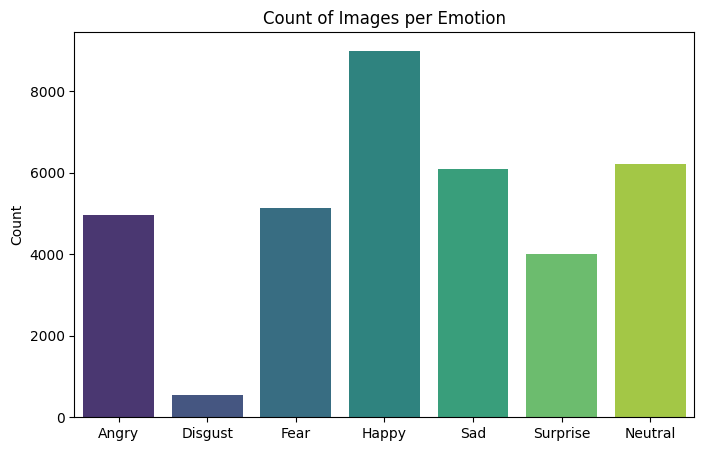

In [57]:
# Count per emotion
emotion_counts = df['emotion'].value_counts().sort_index()
emotion_types = [emotion_dict[i] for i in emotion_counts.index]

# Plot bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=emotion_types, y=emotion_counts.values, palette="viridis")

plt.title("Count of Images per Emotion")
#plt.xlabel("Emotion")
plt.ylabel("Count")

plt.show()

### Visualize the images form our dataset:

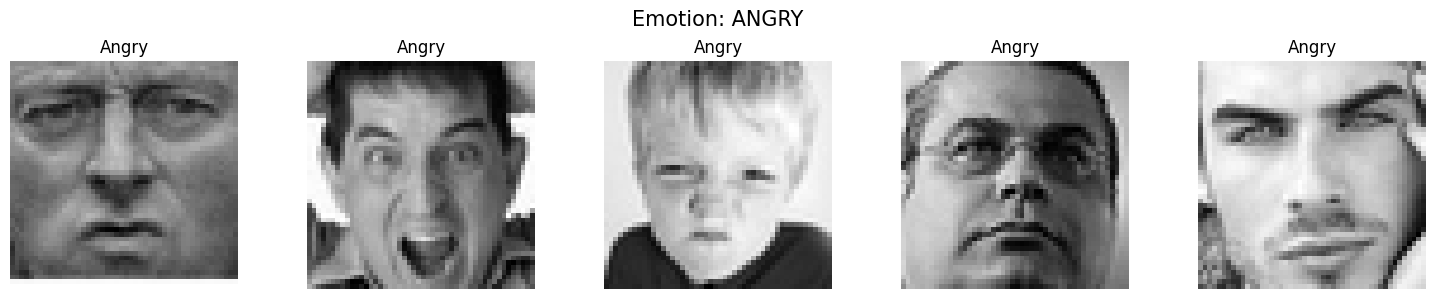

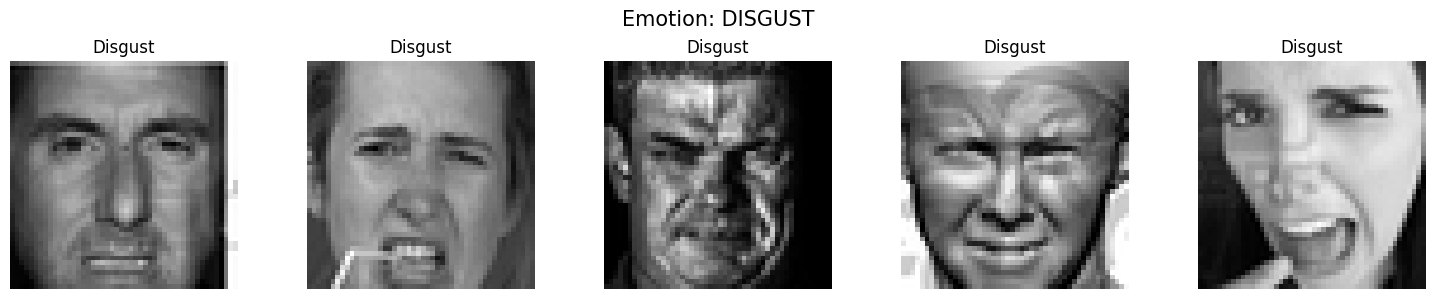

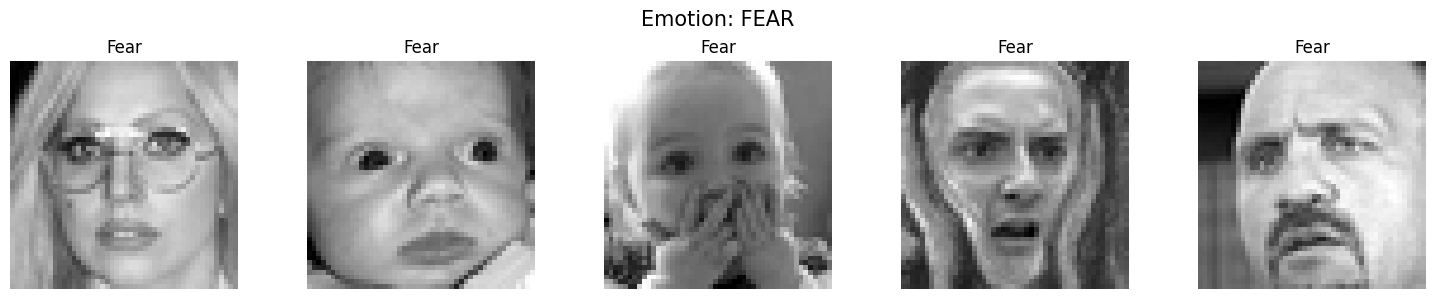

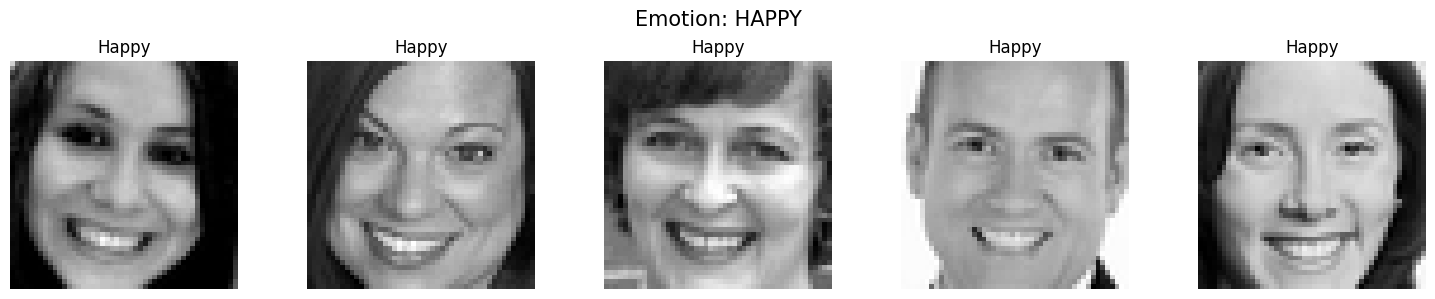

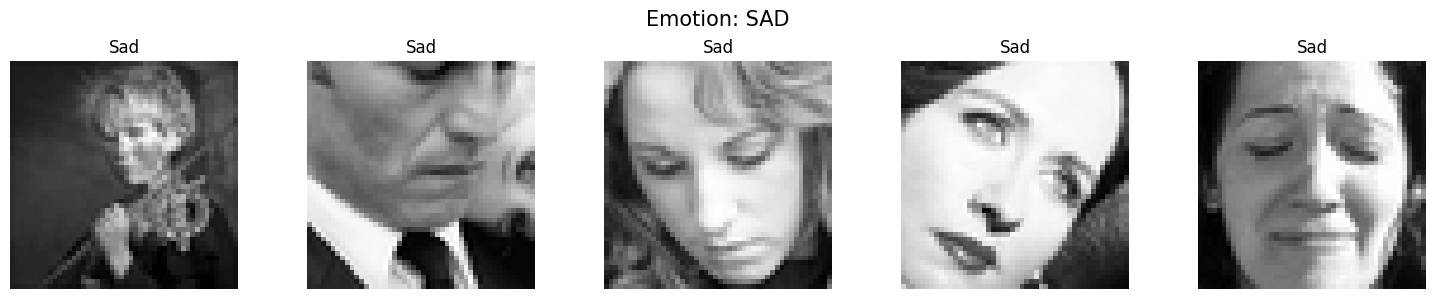

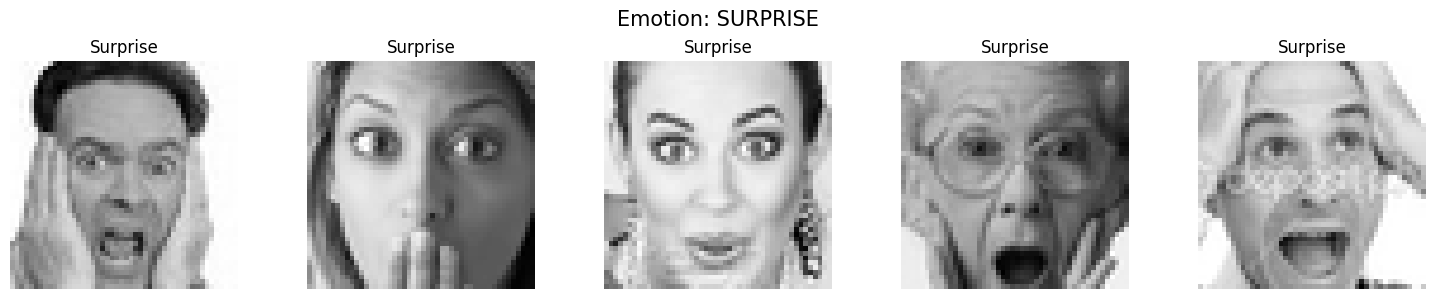

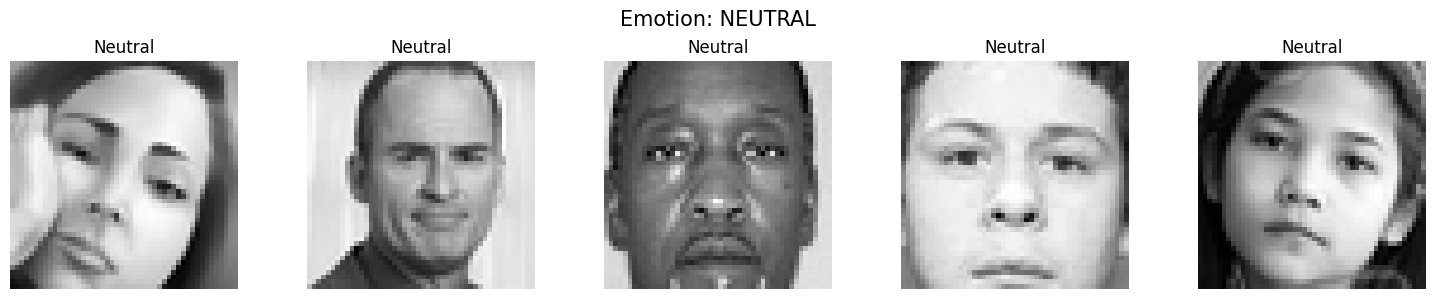

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(emotion, n=5):
    """
    Display n images for a given emotion from the fer2013 dataframe.
    """
    
    # Map emotion name back to its numeric label
    label = [k for k, v in emotion_dict.items() if v.lower() == emotion.lower()]
    if not label:
        print(f"Emotion '{emotion}' not found in emotion_dict.")
        return
    label = label[0]

    # Sample n images for that emotion
    subset = df[df['emotion'] == label].sample(n, random_state=42)

    plt.figure(figsize=(15, 3))
    for i, (_, row) in enumerate(subset.iterrows()):
        img = np.fromstring(row['pixels'], sep=' ').reshape(48, 48)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(emotion)
        plt.axis('off')

    plt.suptitle(f"Emotion: {emotion.upper()}", fontsize=15)
    plt.tight_layout()
    plt.show()


# Calling function:
for emotion in emotion_types:
    show_images(emotion)

---

In [59]:
## Making data compatible for neural network:

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis = 0)

img_array.shape

(35887, 48, 48)

In [61]:
import cv2

img_features = []

for i in range(len(img_array)):
    temp = cv2.cvtColor(img_array[i], cv2.COLOR_GRAY2RGB)
    img_features.append(temp)

img_features = np.array(img_features)
print(img_features.shape)

(35887, 48, 48, 3)


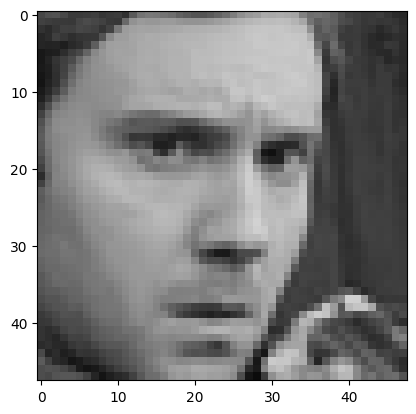

In [62]:
plt.imshow(img_features[0].astype(np.uint8));

In [63]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels) 
img_labels.shape

(35887, 7)

In [64]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}


In [65]:
# ====================================
#  SPLIT DATASET: training and validation
# ====================================

X_train, X_valid, y_train, y_valid = train_test_split(img_features, 
                                                      img_labels, 
                                                      shuffle = True, 
                                                      stratify = img_labels, 
                                                      test_size = 0.1, 
                                                      random_state = 42)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((32298, 48, 48, 3), (3589, 48, 48, 3), (32298, 7), (3589, 7))

In [66]:
del df
del img_features
del img_labels

In [67]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [68]:
X_train = X_train / 255.
X_valid = X_valid / 255.

In [69]:
# ====================================
#  TRANSFER LEARNING: Pre-Trained model VGG19
# ====================================

# Load pre-trained VGG19
model_vgg = tf.keras.applications.VGG19(weights = 'imagenet', 
                                        include_top = False,
                                        input_shape = (48, 48, 3))

This code makes all layers of a VGG19 model non-trainable. 
- This allows the model to be applied to a new problem using only pre-learned features, rather than reflecting changes in the training data to the model, while preserving the pre-trained weights.
- In particular, while developing a facial emotion recognition model using the VGG19 model, the pre-trained weights of the model are preserved, allowing it to be used in solving a new emotion recognition problem.
- In this way, it may be possible to obtain better results using less data.

In [70]:
model_vgg.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
def build_model(bottom_model, classes):
    
    model = bottom_model.layers[-2].output
    model = GlobalAveragePooling2D()(model)
    model = Dense(classes, activation = 'softmax', name = 'out_layer')(model)
    
    return model

In [72]:
head = build_model(model_vgg, num_classes)

model = Model(inputs = model_vgg.input, outputs = head)

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 20,027,975 (76.40 MB)

 Non-trainable params: 0 (0.00 B)

None


In [73]:
early_stopping = EarlyStopping(monitor = 'val_accuracy', 
                               min_delta = 0.00005, 
                               patience = 11,
                               verbose = 1, 
                               restore_best_weights = True,)

lr_scheduler = ReduceLROnPlateau(monitor = 'val_accuracy', 
                                 factor = 0.5, 
                                 patience = 7,
                                 min_lr = 1e-7,
                                 verbose = 1,)

callbacks = [early_stopping,lr_scheduler,]

In [74]:
train_datagen = ImageDataGenerator(rotation_range = 15,
                                   width_shift_range = 0.15,
                                   height_shift_range = 0.15,
                                   shear_range = 0.15,
                                   zoom_range = 0.15,
                                   horizontal_flip = True,)
train_datagen.fit(X_train)

In [75]:
# batch size of 32 performs the best.
batch_size = 32 
epochs = 25
optims = [optimizers.Adam(learning_rate = 0.0001, 
                          beta_1 = 0.9, 
                          beta_2 = 0.999),]

model.compile(loss = 'categorical_crossentropy',
              optimizer = optims[0],
              metrics = ['accuracy'])

In [88]:
from tensorflow.keras.applications.vgg19 import preprocess_input

# Preprocess both training and validation sets
X_train_preprocessed = preprocess_input(X_train)
X_valid_preprocessed = preprocess_input(X_valid)

In [89]:
history = model.fit(train_datagen.flow(X_train_preprocessed, y_train, batch_size=batch_size),
                    validation_data=(X_valid_preprocessed, y_valid),
                    steps_per_epoch=int(len(X_train) / batch_size),
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 75s 74ms/step - accuracy: 0.2429 - loss: 2.0636 - val_accuracy: 0.2505 - val_loss: 1.8138 - learning_rate: 1.0000e-04
Epoch 2/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1562 - loss: 1.8779 - val_accuracy: 0.2505 - val_loss: 1.8136 - learning_rate: 1.0000e-04
Epoch 3/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 74s 73ms/step - accuracy: 0.2507 - loss: 1.8132 - val_accuracy: 0.2505 - val_loss: 1.8110 - learning_rate: 1.0000e-04
Epoch 4/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2188 - loss: 1.7981 - val_accuracy: 0.2505 - val_loss: 1.8110 - learning_rate: 1.0000e-04
Epoch 5/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 74s 73ms/step - accuracy: 0.2443 - loss: 1.8168 - val_accuracy: 0.2505 - val_loss: 1.8116 - learning_rate: 1.0000e-04
Epoch 6/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3125 - loss: 1.6849 - val_accuracy: 0.2505 - val_loss: 1.8115 - learning_rate: 1.0000e-04
Epoch 7/25
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 74s 

In [90]:
# ====================================
#  EVALUATION
# ====================================

'''score = model.evaluate(X_valid, y_valid, verbose=1)
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])'''

val_loss, val_acc = model.evaluate(X_valid_preprocessed, y_valid, verbose=0)
print(f"✅ Validation Accuracy: {val_acc * 100:.2f}%")

✅ Validation Accuracy: 25.05%


---

### TEST - VGG16 MODEL

In [92]:
# ====================================
#  IMPORT LIBRARIES
# ====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# ====================================
#  LOAD DATASET
# ====================================
df = pd.read_csv('/kaggle/input/facialexpressionrecognition/fer2013.csv')

emotion_dict = {
    0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy",
    4: "Sad", 5: "Surprise", 6: "Neutral"
}

# Convert pixel strings to arrays
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48).astype('float32'))
img_array = np.stack(img_array, axis=0)

# Convert grayscale to RGB
img_features = np.array([cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) for img in img_array])

# Encode labels
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)

# ====================================
#  SPLIT DATA
# ====================================
X_train, X_valid, y_train, y_valid = train_test_split(
    img_features, img_labels,
    test_size=0.2,
    stratify=img_labels,
    random_state=42
)

# Normalize
X_train = X_train / 255.
X_valid = X_valid / 255.

img_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

# ====================================
#  TRANSFER LEARNING: VGG16
# ====================================
base_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=img_shape
)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(num_classes, activation='softmax', name='out_layer')(x)

model = Model(inputs=base_model.input, outputs=output)
print(model.summary())

# ====================================
#  CALLBACKS
# ====================================
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks  = [early_stopping, lr_scheduler]

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out_layer (Dense)               │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,718,279 (56.15 MB)

 Trainable params: 3,591 (14.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [93]:
# ====================================
#  DATA AUGMENTATION
# ====================================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)
train_datagen.fit(X_train)

# ====================================
#  TRAINING
# ====================================
batch_size = 32
epochs = 25

optimizer = optimizers.Adam(learning_rate=0.0001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=int(len(X_train) / batch_size),
    epochs=epochs,
    callbacks=callbacks
)

# ====================================
#  EVALUATION
# ====================================
score = model.evaluate(X_valid, y_valid, verbose=1)
print("Validation Loss:", score[0])
print("Validation Accuracy:", score[1])

y_pred = model.predict(X_valid)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=list(emotion_dict.values())))


Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.2011 - loss: 1.9691 - val_accuracy: 0.2799 - val_loss: 1.7531 - learning_rate: 1.0000e-04
Epoch 2/25
  1/897 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0938 - loss: 1.9070

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.0938 - loss: 1.9070 - val_accuracy: 0.2795 - val_loss: 1.7530 - learning_rate: 1.0000e-04
Epoch 3/25
897/897 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.2726 - loss: 1.7598 - val_accuracy: 0.3157 - val_loss: 1.7035 - learning_rate: 1.0000e-04
Epoch 4/25
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3125 - loss: 1.7271 - val_accuracy: 0.3157 - val_loss: 1.7036 - learning_rate: 1.0000e-04
Epoch 5/25
897/897 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.3000 - loss: 1.7235 - val_accuracy: 0.3253 - val_loss: 1.6784 - learning_rate: 1.0000e-04
Epoch 6/25
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3438 - loss: 1.7531 - val_accuracy: 0.3256 - val_loss: 1.6784 - learning_rate: 1.0000e-04
Epoch 7/25
897/897 ━━━━━━━━━━━━━━━━━━━━ 27s 30ms/step - accuracy: 0.3189 - loss: 1.7029 - val_accuracy: 0.3324 - val_loss: 1.6675 - learning_rate: 1.0000e-04
Epoch 8/25
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.437

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [100]:
print("✅ Validation Accuracy:", round(score[1]*100,1), "%")

✅ Validation Accuracy: 37.0 %
